In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx
from pathlib import Path
import subprocess

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.utils import add_features
from src.data.continents_clusters import regions

In [2]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

In [3]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns. Only 
# duplicate movies with equal countries are kept
df_movies = cleaning.drop_most_missing(df_movies, ['title', 'countries'])

In [4]:
# doing the same duplicates cleaning as before for df_tmdb, considering 
# 'production_countries' instead of 'countries'
df_tmdb = cleaning.drop_most_missing(df_tmdb, ['title', 'production_countries'])

In [5]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [6]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [7]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [8]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [9]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [10]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [11]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Text(0, 0.5, 'Count of Ratings')

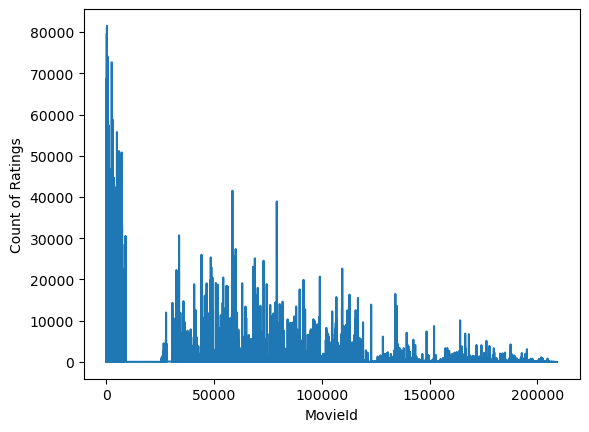

In [12]:
# testing how many ratings each movie has
ratings_distirbution = df_ratings_ratings.groupby("movieId").count()
ratings_distirbution = ratings_distirbution.reset_index()
plt.plot(ratings_distirbution["movieId"], ratings_distirbution["userId"])
plt.xlabel("MovieId")
plt.ylabel("Count of Ratings")

In [13]:
# filtering for movies with over 10 ratings
ratings_count = df_ratings_ratings.groupby("movieId")["rating"].count()
movies_with_10_plus_ratings = ratings_count[ratings_count > 10].index
filtered_ratings = df_ratings_ratings[df_ratings_ratings["movieId"].isin(movies_with_10_plus_ratings)].copy()

# taking the mean of each movie's rating
mean_ratings = filtered_ratings.groupby("movieId").mean()

# making the mean of each movie's rating an increment of 0.5
# mean_ratings["rating"] = filtered_ratings["rating"].apply(lambda x: round(x*2)/2)
mean_ratings = mean_ratings.reset_index()

In [14]:
# further cleaning of the ratings dataset is required before merging to the movies metadata
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 14073 unique movies in our movies dataset that have ratings given by the found dataset.


In [15]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [16]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

In [17]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones -> Jake added, below, cleaning of the genres to avoid redundancy
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# making every genre's text uniform to assess unique genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.lower()

# removing redundant verbiage for genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" movies", "")

# fixing some genres being as lists
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].map(str)
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("[", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("]", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("'", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace('"', "")

In [18]:
# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [19]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones -> Jake added further cleaning of genres before choosing the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.lower()

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].map(str)
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("[", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("]", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("'", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace('"', "")

df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# cleaning the single genre movies' genres
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.lower()

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" film", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("[", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("]", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("'", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace('"', "")

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

The mean number of countries of a given movie is:  2


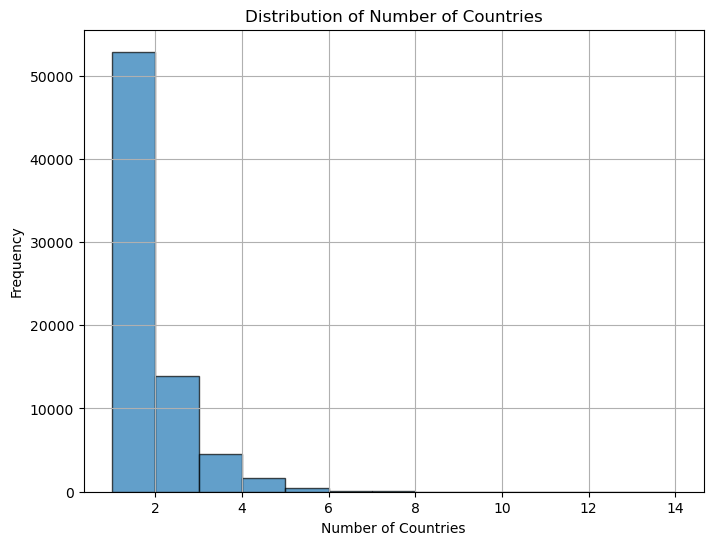

In [20]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Countries')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')
plt.grid(True)

In [21]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [22]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [23]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

In [24]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 13889 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


In [25]:
# deleting not used dataframes (but keeping the original ones)
del df_movies_tmdb
del df_movies_tmdb_ratings_exploded
del df_movies_tmdb_ratings_multi
del df_ratings_linked

# Historical Proximity Score

The dataframe must be filled manually. Entries are in range from -1 to 1. 
Taking into account that a movie takes minimum a year to produce (in general), if a meaningful historical event happens, a score of 1 is given to the exact year of the event and the year later, then the score lowers by 0.2 each year. Therefore, an historical event has a decreasing impact on movies for the next 5 years. If the event is positive, the score is positive, viceversa if the event is negative. Events for each country are asked to ChatGPT.

In [26]:
# saving df_movies_tmdb_ratings as a pickle file
output_path = Path("src/scripts/df_movies_tmdb_ratings.pkl")
df_movies_tmdb_ratings.to_pickle(output_path)

# running historical_proximity.py script
result = subprocess.run(["python", "src/scripts/historical_proximity.py"], capture_output=True, text=True)

# if the script failed, print the error message
if result.returncode != 0:
    print("Error occurred:")
    print(result.stderr)
else:
    print("Script ran successfully.")

# loading historical_proximity_score
historical_proximity_score = pd.read_pickle("src/scripts/historical_proximity_score.pkl")

Script ran successfully.


In [27]:
# checking if there are any rows with only zeros
rows_with_zeros = historical_proximity_score.loc[(historical_proximity_score == 0).all(axis=1)]

if not rows_with_zeros.empty:
    print("There are rows with only zeros.")
else:
    print("No rows with only zeros.")

No rows with only zeros.


In [28]:
# adding historical_proximity_score column
df_movies_tmdb_ratings['historical_proximity_score'] = df_movies_tmdb_ratings.apply(
    lambda row: add_features.get_historical_proximity_score(row, historical_proximity_score), axis=1
)

Adding genre complexity score

In [29]:
# defining unique_genres_per_movie series
unique_genres_per_movie = (
    df_movies_tmdb_ratings.explode('genres') 
    .groupby('title')['genres'].nunique()
)

# get_genre_complexity_score() call
complexity_dict = add_features.get_genre_complexity_score(unique_genres_per_movie)

# new dataframe column
df_movies_tmdb_ratings['genre_complexity_score'] = df_movies_tmdb_ratings['title'].map(complexity_dict)

Adding region column to the dataframe and extracting top20 genres, even tho this needs to be updated.

In [30]:
# map_regions() call
country_to_region = add_features.map_regions(regions)

# mapping the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped.
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

In [31]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

# Characters Dataset Cleaning

Analogous to the movie metadata, the characters dataset must be wrangled.

In [32]:
# clean characters 'release_date' and 'actor_birth' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

The datastory will most focus on actor ethnicity, therefore particular attention is payed to the related columns in `df_characters`.

In [33]:
# counting the number of unique values in 'actor_ethnicity', excluding NaN
print(f"Number of unique ethnicities in 'actor_ethnicity': {df_characters['actor_ethnicity'].nunique(dropna=True)} \n")

# counting the number of NaN values in 'actor_ethnicity'
print(f"Number of NaN values in 'actor_ethnicity': {df_characters['actor_ethnicity'].isna().sum()}")

# total number of entries in 'actor_ethnicity' column
print(f"Total entries in 'actor_ethnicity': {len(df_characters['actor_ethnicity'])}")

# NaN entries proportion
nan_proportion_ethnicity = df_characters['actor_ethnicity'].isna().sum() / len(df_characters['actor_ethnicity'])
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")

Number of unique ethnicities in 'actor_ethnicity': 479 

Number of NaN values in 'actor_ethnicity': 344611
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%


Actors' ethnicities are in the format of Freebase IDs. To translate them, these unique IDs have been saved in a `.txt` file, which has been translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}

The creation of the `.txt` file is achieved by `src/data/freebase_to_batches.py` and the result is `src/data/unique_actor_ethnicities_batexhes.txt`. The outputs from query.wikidata.org have been saved in a .csv file (`freebaseids_labels.csv`)

In [34]:
# defining src/data/ path
SRC_DATA = './src/data/'

# reading the .csv and saving it to a dataframe
df_labels = pd.read_csv(SRC_DATA + 'freebaseids_label.csv')
df_labels.columns = ['freebase_id', 'wikipedia_id', 'label']  

# mapping dictionary definition
freebase_to_label = dict(zip(df_labels['freebase_id'], df_labels['label']))

# creating 'ethnicity_label' column where to map the freebse ethnicity Ids to the 
# corresponding labels
df_characters['ethnicity_label'] = df_characters['actor_ethnicity'].map(freebase_to_label)

In [35]:
# calculating the proportion of nans in 'ethnicity_label'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])

# checking if any information have been lost during the ids-label translation
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")
print(f"Proportion of NaN values in 'ethnicity_label': {nan_proportion_label:.2%}")

Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of NaN values in 'ethnicity_label': 77.17%


In [36]:
# printing some of the counts of unique values in 'ethnicity_label', excluding NaN
print("Unique values in 'ethnicity_label' and their counts:")
print(df_characters['ethnicity_label'].value_counts(dropna=True).head(10)) 

Unique values in 'ethnicity_label' and their counts:
ethnicity_label
Indians               16351
African Americans     10159
Jewish people         10121
English people         6165
Irish Americans        3857
Italian Americans      2956
White people           2307
White Americans        2250
Scottish Americans     2223
Irish people           1637
Name: count, dtype: int64


### Clustering Ethnicities & Adding Nationalities & Ethnicities from Wikidata:

In [37]:
# Load the dictionary from the .txt file
with open(SRC_DATA + "ethnicities_clusters.txt", "r") as file:
    ethnicities_clusters = ast.literal_eval(file.read())

In [38]:
#defining the ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        #checking if the label is already in the dictionary
        if label not in ethnicity_to_clusters:
            # init a new empty list
            ethnicity_to_clusters[label] = []
        # Add the cluster if not already in the list to avoid duplicates
        if cluster not in ethnicity_to_clusters[label]:
            ethnicity_to_clusters[label].append(cluster)

# Map each character's ethnicity to its unique clusters
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity_to_clusters.get(ethnicity, [])
)


In [39]:
# searching unique ethnicity labels where 'mapped_clusters' is missing
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].isna()]['ethnicity_label'].unique()

Since the labels are still incomplete for a large part, information from wikidata is adopted to enrich the `df_characters` dataframe. For each actor (using his freebase_id), a query has been requested to retrieve ethnicity or nationality if available. Everything is saved in `wikidata_actor_info.csv`.

In [40]:
# reading the .csv as a dataframe
df_wikidata = pd.read_csv(SRC_DATA + 'wikidata_actor_info.csv', sep=',')

# left merging df_characters and df_wikidata
df_characters = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

In [41]:
# Filling 'ethnicity_label', where necessary, with the new labels extracted from wikidata
# (either 'ethnicityLabel' or 'nationalityLabel' if the first is NaN or ambiguous)
def fill_ethnicity(row):
    if row['ethnicity_label'] in unmatched_ethnicities:
        # If the ethnicity is ambiguous, retrieve the nationality
        return row['nationalityLabel'] if pd.notna(row['nationalityLabel']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['ethnicity_label'])
    else:
        # For non-ambiguous cases, retrieve the ethnicity label associated to it or fallback to nationality
        return row['ethnicity_label'] if pd.notna(row['ethnicity_label']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['nationalityLabel']
        )

df_characters['ethnicity_label'] = df_characters.apply(fill_ethnicity, axis=1)

# printing the final results
print(f"Before filling, the proportion of NaN values in 'ethnicity_label' was: {nan_proportion_label:.2%}")

# re-computing the proportion of nan in 'ethnicity_labels'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])
print(f"After filling, the proportion of NaN values in 'ethnicity_label' is: {nan_proportion_label:.2%}")


Before filling, the proportion of NaN values in 'ethnicity_label' was: 77.17%
After filling, the proportion of NaN values in 'ethnicity_label' is: 36.54%


The proportion of missing values in `'ethnicity_label'` has been halved through filling it with wikidata information. This allows to save a big part of the original dataframe when dropping nan values in the `'ethnicity_label'` column. Now, new ethnicities can be mapped to the clusters in `ethnicities_clusters.txt` file, after updating the latter. Note that, for simplicity, only the last updated version of this file is stored in `/src/data/`, therefore also in the first clustering this version has been adopted. 

In [42]:
new_ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        new_ethnicity_to_clusters.setdefault(label, []).append(cluster)

df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: list(set(new_ethnicity_to_clusters.get(ethnicity, [])))
)

In [43]:
# Identify unmatched ethnicity labels
unmatched_ethnicities = df_characters[df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label']

# Count occurrences of unmatched ethnicity labels
unmatched_ethnicities_counts = unmatched_ethnicities.value_counts()

# Print the total number of unique unmatched ethnicity labels
print(f"Number of unmatched ethnicity labels: {unmatched_ethnicities_counts.shape[0]}")

# Print unmatched ethnicity labels with their counts
print("Unmatched ethnicity labels and their counts:")
print(unmatched_ethnicities_counts)

Number of unmatched ethnicity labels: 6
Unmatched ethnicity labels and their counts:
ethnicity_label
مسح                        9
multiracial people         4
Q25589681                  4
Karay-a people             2
Bohemian People            1
peoples of the Caucasus    1
Name: count, dtype: int64


For some ambiguous ethnicities, "Jewish People" whose actors may have several ethnicities/nationalities we attributed them to the category middle east as it accounts for Israel too. And Jewish in India were considered Israelian Jews also. Idk if we should precise that. 

In [44]:
# dropping useless columns
#["freebase_id", "character_name", "actor_birth", "actor_height", "freebase_map","actor_ethnicity" ,"freebaseID","actorLabel", "nationalityLabel"], inplace=True)
df_characters= df_characters.drop(['freebaseID'], axis = 1)
df_characters= df_characters.drop(['actorLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicityLabel'], axis = 1)
df_characters= df_characters.drop(['nationalityLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicity_label'], axis = 1)
df_characters= df_characters.drop(['freebase_character_id'], axis = 1)
df_characters= df_characters.drop(['freebase_map'], axis = 1)
df_characters= df_characters.drop(['actor_height'], axis = 1)
df_characters= df_characters.drop(['character_name'], axis = 1)
df_characters=df_characters.drop(['actor_ethnicity'], axis = 1)
df_characters=df_characters.drop(['freebase_id'], axis = 1)

In [45]:
#renaming mapped cluster column
df_characters = df_characters.rename(columns={'mapped_clusters': 'actor_ethnicity'})


- This is the minimum of ambiguous ethnicities we could have. Those will remain inclassified since our analysis focuses on regions. 
- No dropping NA's for now as we will be investigating ethnicities and genders.

In [46]:
#deleting useless dfs
del df_labels
del df_wikidata
del unmatched_ethnicities
del unmatched_ethnicities_counts

## Merging characters with master dataframe for primary plots mainly

In [47]:
#creting new df merging character's data with master dataframe
df_movies_tmdb_ratings_characters = pd.merge(df_characters[['wikipedia_id','actor_gender','actor_ethnicity','freebase_actor_id']],
                             df_movies_tmdb_ratings_unique[['wikipedia_id','countries', 'title', 'release_date','genres','mean_rating','mean_rating_timestamp','region']], 
                             on='wikipedia_id', how='inner')


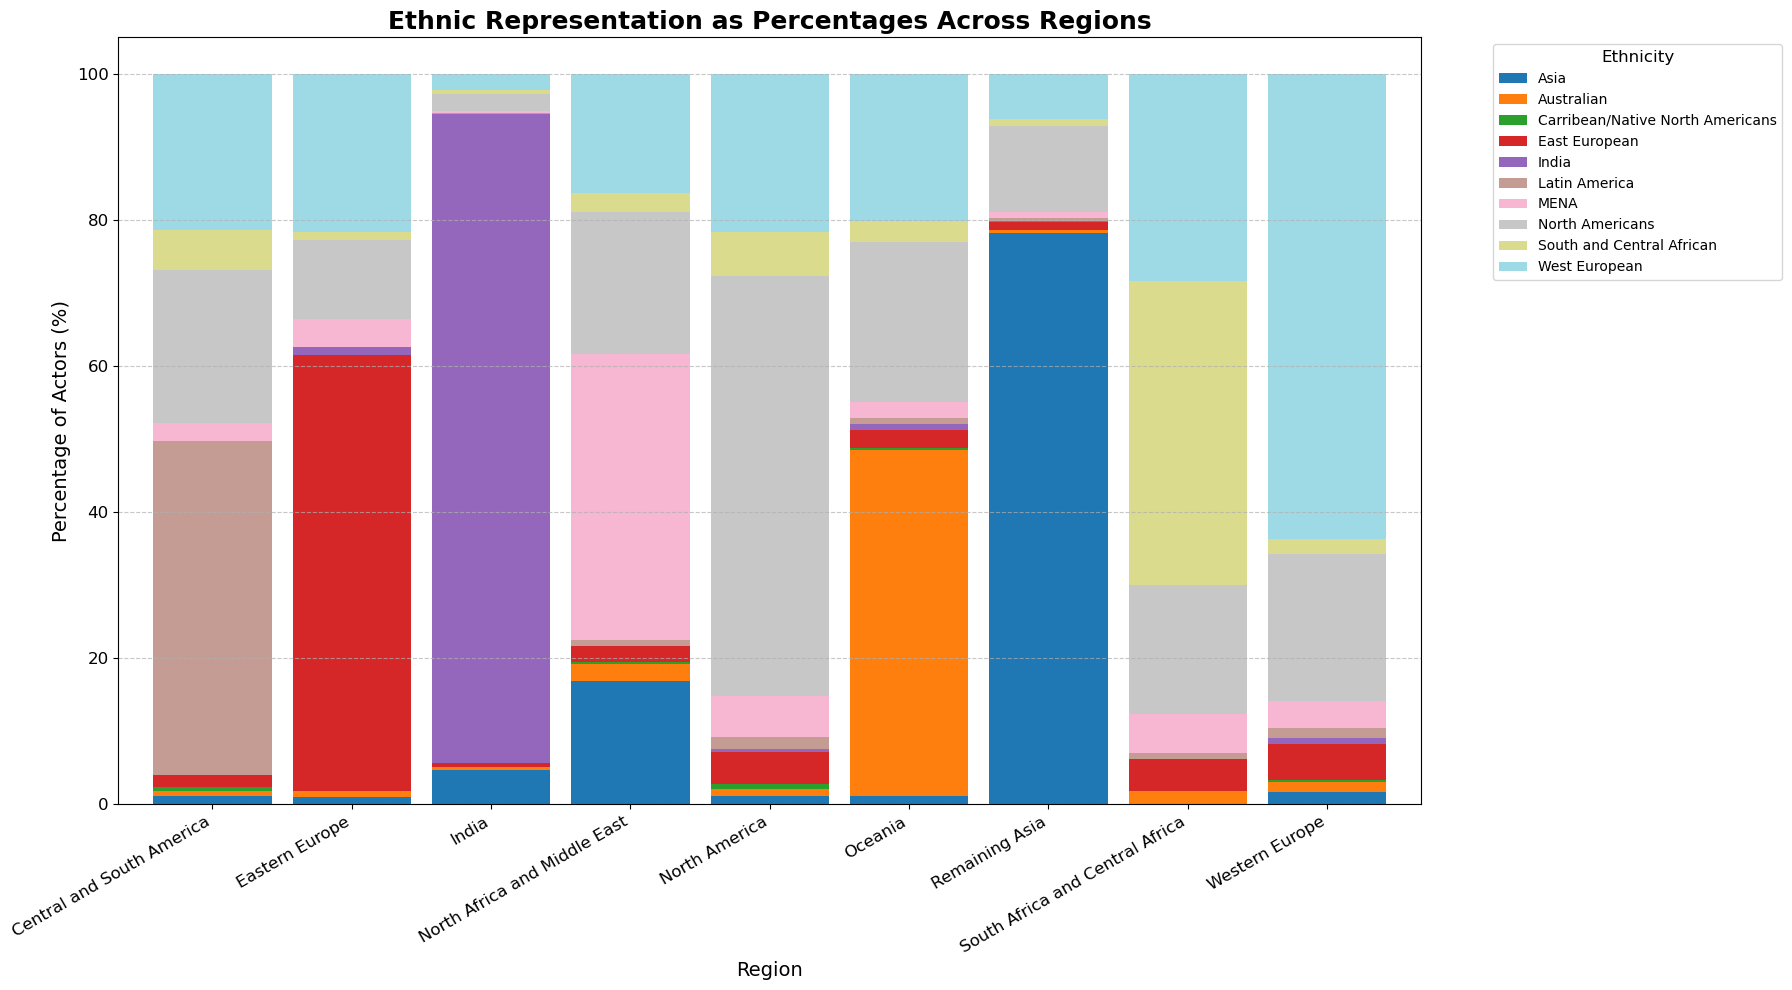

In [48]:
# Filter rows where both 'regions' and 'mapped_clusters' are not NaN
df_characters_region_ethnicity = df_movies_tmdb_ratings_characters.dropna(subset=['region', 'actor_ethnicity'])

# Explode the 'mapped_clusters' column to handle lists
df_characters_region_ethnicity_exploded = df_characters_region_ethnicity.explode('actor_ethnicity')

# Ethnicity representation by region
region_ethnicity_trends = df_characters_region_ethnicity_exploded.groupby(['region', 'actor_ethnicity']).size().unstack(fill_value=0)

# Calculate percentages for each region
region_ethnicity_percent = region_ethnicity_trends.div(region_ethnicity_trends.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart with percentages
plt.figure(figsize=(18, 10))  # Larger figure size for readability
region_ethnicity_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Regions", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()


## Creating the Ethnicity score - using characters dataframe

What interests us is how the demographics of the cast members of one movie may impact it's ratings. We'll look at their ethnicities and their genders. This two features have to be quantified through an ethnicity_score and a gender_score per movie, reflecting not only the proportions but the distribution of the cast. A movie with 10 ethnicities represented equally (balanced distribution) should score higher in diversity than a movie with 10 ethnicities but dominated by one ethnicity. This is where the Shannon Diversity Index (SDI) becomes valuable because we are not capturing the true spread of diversity.
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
$$
H = - \sum_{i=1}^{n} p_i \ln(p_i)
$$

Where:

- \(H\): Shannon Diversity Index  
- \(p_i\): Proportion of individuals in the \(i\)-th category (ethnicity)  
- \(n\): Total number of categories (ethnicities)  




## 1-Ethnicity Score 

First we create a new dataframe which will contain the movie_id , number of characters of each movie , and proportion of individuals of each ethnicity in each movie, and finally the SDI ethnicity score for each movie. 

In [49]:
#filtering actors with no ethnicities by filtering nans and empty lists
df_filtered = df_characters[
    df_characters['actor_ethnicity'].notna() & df_characters['actor_ethnicity'].apply(lambda x: len(x) > 0)
]

In [50]:
#Df for ethnicity diversity score
df_ethnicity_exploded = df_filtered.explode('actor_ethnicity')

In [51]:
# Occurrences of each ethnicity per movie
ethnicity_counts = df_ethnicity_exploded.groupby(['wikipedia_id', 'actor_ethnicity']).size().reset_index(name='ethnicity_count')
# since df_ethnicity is exploded based on ethnicities, counting the nb of entries simply gives total nb of ethnicities in the movie
total_actors = df_ethnicity_exploded.groupby('wikipedia_id').size().reset_index(name='total_actors')
# Merge counts back into exploded dataframe
df_ethnicity_counts = ethnicity_counts.merge(total_actors, on='wikipedia_id')
# Proportions for each ethnicity
df_ethnicity_counts['ethnicity_proportion'] = df_ethnicity_counts['ethnicity_count'] / df_ethnicity_counts['total_actors']


In [52]:
def shannon_entropy(proportions):
    """
    Calculates the Shannon entropy given a list or series of proportions.
    
    Parameters:
    proportions (list or pd.Series): Proportions of categories in a group.
    
    Returns:
    float: Shannon entropy (diversity index).
    """
    return -np.sum(proportions * np.log(proportions))

In [53]:
# Calculate SDI for each movie
df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['ethnicity_proportion'])
).reset_index(name='SDI_ethnicity')

# Merge the SDI scores back to the original dataframe
df_ethnicity_counts = df_ethnicity_counts.merge(df_sdi, on='wikipedia_id')

#Drop duplicates for distribution analysis 
df_ethnicity_counts = df_ethnicity_counts.drop_duplicates(subset='wikipedia_id')


C:\Users\bosca\AppData\Local\Temp\ipykernel_14004\3702374300.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(


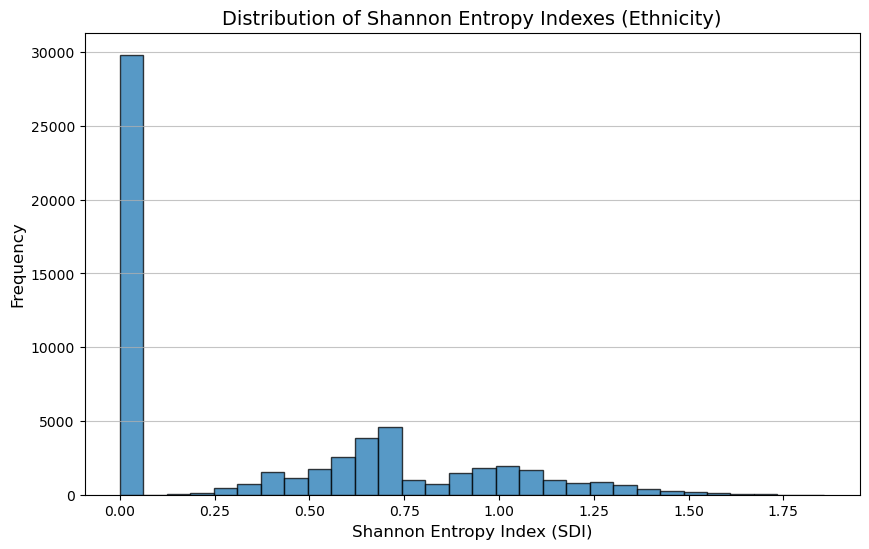

In [54]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_ethnicity_counts['SDI_ethnicity'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Ethnicity)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

High values = High diversity and balanced distribution of the ethnicities of the cast, no dominance of one ethnicity over the others. 
Lower value = No diversity / All cast members have the same one ethnicity. 

## 2-Gender Score 

## A -Shannon diversity index

In [55]:
df_characters_gender = df_characters.dropna(subset=['actor_gender'])

In [56]:
# For Gender Diversity Index (SDI)
# Ooccurrences of each gender per movie
gender_counts = df_characters_gender.groupby(['wikipedia_id', 'actor_gender']).size().reset_index(name='gender_count')
# Total number of actors per movie
total_actors_per_movie = df_characters_gender.groupby('wikipedia_id').size().reset_index(name='total_actors')
#Merge the counts back into a single dataframe
df_gender_counts = gender_counts.merge(total_actors_per_movie, on='wikipedia_id')
# Proportions for each gender
df_gender_counts['gender_proportion'] = df_gender_counts['gender_count'] / df_gender_counts['total_actors']

# Step 5: Calculate SDI for each movie
df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['gender_proportion'])
).reset_index(name='SDI_gender')

# Merge the SDI scores back
df_gender_counts = df_gender_counts.merge(df_sdi_gender, on='wikipedia_id')
#dropping duplicates keeping unique entry per movie 
df_gender_counts = df_gender_counts.drop_duplicates(subset='wikipedia_id')
df_gender_counts.head()


C:\Users\bosca\AppData\Local\Temp\ipykernel_14004\2184839285.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_gender,gender_count,total_actors,gender_proportion,SDI_gender
0,330,F,4,4,1.000000,-0.000000
1,3217,F,3,13,0.230769,0.540204
3,3333,F,6,15,0.400000,0.673012
5,3746,F,3,14,0.214286,0.519580
7,3837,F,2,20,0.100000,0.325083


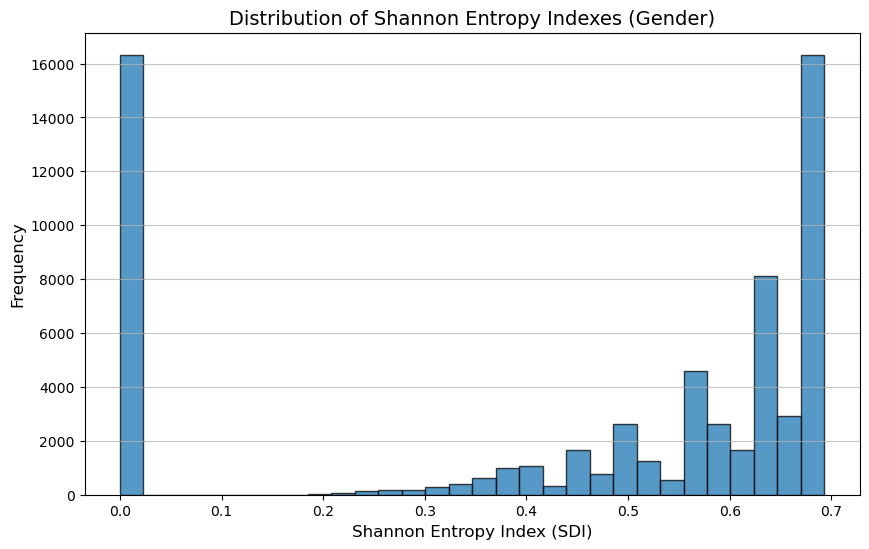

In [57]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_gender_counts['SDI_gender'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Gender)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

Here, many films cluster around a moderate to relatively high SDI (around 0.6–0.7), suggesting that a substantial portion have a fairly mixed gender distribution, while a noticeable subset score near zero, indicating casts composed of only one gender.

## Now back to the original data frame: 

Adding Diversity and gender scores to original master dataframe. 

In [58]:
# Merge SDI_ethnicity
df_movies_tmdb_ratings = df_movies_tmdb_ratings.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)
# Merge SDI_gender and GPR
df_movies_tmdb_ratings = df_movies_tmdb_ratings.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)


In [59]:
# Adding nb of actors per movie:
#Number of actors per movie: 
# Unique actors per movie as each entry of df_characters is a character in the movie 
actors_per_movie = df_characters.groupby('wikipedia_id')['freebase_actor_id'].nunique()
# Map the count back to the original dataframe
df_movies_tmdb_ratings['nb_actors'] = df_movies_tmdb_ratings['wikipedia_id'].map(actors_per_movie)

In [60]:
# deleting not used dataframes (but keeping the original ones)
del df_filtered # df_characters without missing ethnicities
del df_ethnicity_exploded
del total_actors
del df_sdi

del df_characters_gender
del total_actors_per_movie
del df_sdi_gender

# Decision Tree Model

In [61]:
# keeping top 20 clean genres for the decision tree model
genres_total = df_movies_tmdb_ratings.groupby("genres").count().sort_values("wikipedia_id", ascending=False).reset_index()

# extracting top 20 genres
top_20_genres = genres_total.loc[:19, "genres"]

# defining new top 20 genres dataframe
df_movies_tmdb_ratings_top20genres = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_20_genres)]

# resetting indexes
df_movies_tmdb_ratings_top20genres = df_movies_tmdb_ratings_top20genres.reset_index(drop=True)

In [62]:
# Binning mean ratings
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
labels = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]

# Creating new column with .loc to avoid SettingWithCopyWarning
df_movies_tmdb_ratings_top20genres.loc[:, 'binned_rating'] = pd.cut(
    df_movies_tmdb_ratings_top20genres['mean_rating'],
    bins=bins,
    labels=labels,
    right=False
)

In [63]:
from sklearn.preprocessing import LabelEncoder

# aggregating repeated movies to consider only mode of features (to avoid potential bias)
data = df_movies_tmdb_ratings_top20genres.groupby('title').agg({
    'release_date': lambda x: x.mode()[0],
    'revenue': 'mean',
    'runtime': 'mean',
    'genres': lambda x: x.mode()[0],
    'budget': 'mean',
    'historical_proximity_score': 'mean',
    'genre_complexity_score': 'mean',
    'region': lambda x: x.mode()[0],
    'binned_rating': lambda x: x.mode()[0]
}).reset_index()

# keeping only some features and specifing the target variable
features = df_movies_tmdb_ratings_top20genres[
    [
        'release_date',
        'revenue',
        'runtime',
        'genres',
        'budget',
        'historical_proximity_score',
        'genre_complexity_score',
        'region',
        'SDI_ethnicity',
        'SDI_gender',
        'nb_actors',
    ]
]

target = df_movies_tmdb_ratings_top20genres[['binned_rating']]

# encoding target variable to discrete classes
encoder = LabelEncoder()
target = encoder.fit_transform(target)

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
# one-hot encoding of some features (no dropping of the first column)
features = pd.get_dummies(features, columns=['genres', 'region'], drop_first=True)

In [65]:
from sklearn.model_selection import train_test_split

# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# The final number of values in the resulting training and testing dataframes is required
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

The number of samples in the train dataset is: 56409
The number of samples in the test dataset is: 14103


In [66]:
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier call
decision_tree = DecisionTreeClassifier(random_state=42).fit(df_train, df_train_target)

In [67]:
# predicting test set
target_predict = decision_tree.predict(df_test)

# printing depth of the tree
D = decision_tree.get_depth()
print(f'The depth of the decision tree is: {D}')

The depth of the decision tree is: 37


In [68]:
from sklearn.metrics import classification_report

# evaluating metrics
print(classification_report(df_test_target, target_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      0.79      0.85        14
           2       0.78      0.83      0.81       162
           3       0.85      0.81      0.83       852
           4       0.87      0.88      0.88      2836
           5       0.91      0.93      0.92      5672
           6       0.92      0.90      0.91      4308
           7       0.90      0.88      0.89       258

    accuracy                           0.90     14103
   macro avg       0.77      0.75      0.76     14103
weighted avg       0.90      0.90      0.90     14103



c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The best depth in terms of accuracy is: 36


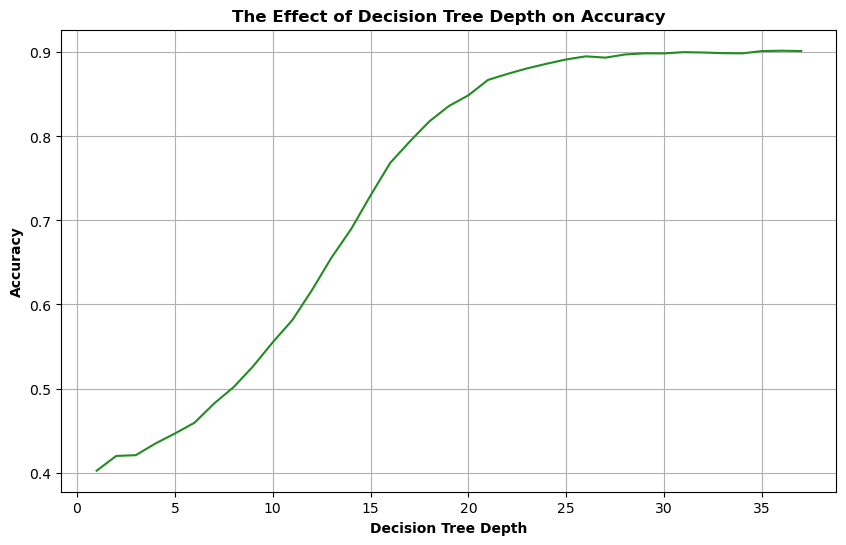

In [69]:
from sklearn.metrics import accuracy_score

# searching D that maximizes accuracy of the model
accuracies = np.zeros(D)

for d in range(0, D):
    decision_tree = DecisionTreeClassifier(max_depth=d+1, random_state=42).fit(df_train, df_train_target)

    # predicting outcomes
    target_predict = decision_tree.predict(df_test)
    accuracies[d] = accuracy_score(df_test_target, target_predict)

# plotting results
plt.figure(figsize=(10, 6))
plt.plot(range(1, D+1), accuracies,  '-', color='forestgreen')
plt.xlabel('Decision Tree Depth',  weight='bold')
plt.ylabel('Accuracy',  weight='bold')
plt.title('The Effect of Decision Tree Depth on Accuracy', weight='bold')
plt.grid(True)

# getting best tree depth
best_acc = np.max(accuracies)
best_d = np.where(accuracies == best_acc)[0]

print(f'The best depth in terms of accuracy is: {best_d[0]+1}')

In [70]:
from sklearn.ensemble import RandomForestClassifier

# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# The final number of values in the resulting training and testing dataframes is required
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

# Create the model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(df_train, df_train_target)

# prediction
target_predict = random_forest.predict(df_test)

# Accuracy
accuracy = accuracy_score(df_test_target, target_predict)
print(f"Accuracy: {accuracy}")

The number of samples in the train dataset is: 56409
The number of samples in the test dataset is: 14103
Accuracy: 0.8986740409841878


In [77]:
# Retrieve feature importances
importances = random_forest.feature_importances_

# Display feature importances
for i, importance in enumerate(importances):
    print(f"Feature {i} ({features.columns[i]}): {importance}")

Feature 0 (release_date): 0.11221655279491921
Feature 1 (revenue): 0.10632278208966238
Feature 2 (runtime): 0.12880598735448032
Feature 3 (budget): 0.09003261300576357
Feature 4 (historical_proximity_score): 0.06421327273358585
Feature 5 (genre_complexity_score): 0.07673581247913043
Feature 6 (SDI_ethnicity): 0.10771884477684708
Feature 7 (SDI_gender): 0.10328715505919185
Feature 8 (nb_actors): 0.09985891178690327
Feature 9 (genres_action/adventure): 0.0035428296717321594
Feature 10 (genres_adventure): 0.00382173835225741
Feature 11 (genres_comedy): 0.0074488307286776625
Feature 12 (genres_crime fiction): 0.004558790401081198
Feature 13 (genres_crime thriller): 0.0024931581934531104
Feature 14 (genres_drama): 0.007738181921595901
Feature 15 (genres_family): 0.0032325825311228015
Feature 16 (genres_fantasy): 0.003228265165640646
Feature 17 (genres_film adaptation): 0.002774392363225218
Feature 18 (genres_horror): 0.004870732350790771
Feature 19 (genres_indie): 0.004372829159324209
Featu

k-fold cross validation on random forest:

In [72]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest, df_train, df_train_target, cv=5)  # 5-fold CV
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Score: {scores.mean()}")

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.88007445 0.88326538 0.87431307 0.87670626 0.87713855]
Mean Score: 0.8782995415449664


In [73]:
scores = cross_val_score(DecisionTreeClassifier(), df_train, df_train_target, cv=5)  # 5-fold CV
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Score: {scores.mean()}")

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.86553803 0.87528807 0.87298351 0.86349938 0.84877227]
Mean Score: 0.8652162519459663
